In [ ]:
from torchvision import models # здесь лежат предобученные сетки

#import argparse
from types import SimpleNamespace # простой класс, где можно прописать параметры
import json

# Для визуализации
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import time
import scipy
from google.colab import files

# Библиотеки Pytorch
import torch 
import torchvision # здесь лежит mnist, cifar и много других датасетов и трансформаций для картинок
import torch.nn as nn # здесь лежат все слои
import torch.utils.data as data # работа с загрузчиком данных
import torchvision.transforms as transforms
import torchvision.datasets as dsets #работа с классом Датасет
from torch.autograd import Variable # для автоматического дифференциатора

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
path = '/content/drive/My Drive/Базы/' 

In [ ]:
config = SimpleNamespace() # Создаем базовый класс пространства имен
config.content = path+'Parakeet.png' # наша основная картинка
config.style1 = path+'microchip.jpg' #  стилизованная картинка 1
config.style2 = path+'fur.jpg' #  стилизованная картинка 2
config.maxSize = 400 # максимально допустимый размер изображения
config.totalStep = 600 # общее количество шагов за эпоху
config.step = 10 # шаг
config.sampleStep = 100 # шаг для сохранения образца
config.styleWeight = 100 #вес на стиль
config.lr = .003 

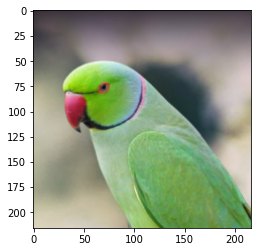

In [ ]:
  plt.imshow(Image.open(config.content))
  plt.show()

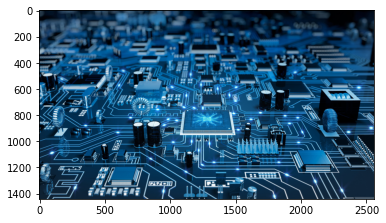

In [ ]:
  plt.imshow(Image.open(config.style1))
  plt.show()

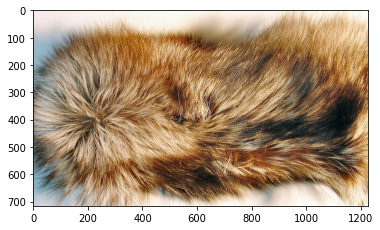

In [ ]:
  plt.imshow(Image.open(config.style2))
  plt.show()

# Построение нейронной сети

In [ ]:
# Проверка, если GPU включен
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cuda')

In [ ]:
vgg = models.vgg19()
vgg

In [ ]:
mob = models.mobilenet_v2()
mob.features[12].conv[0][0]

Conv2d(96, 576, kernel_size=(1, 1), stride=(1, 1), bias=False)

In [ ]:
dir(vgg.layer1[0])

In [ ]:
class PretrainedNet(nn.Module):
    def __init__(self):
        # Инициализируем нашу модель
        super(PretrainedNet, self).__init__()
        self.select = [1, 3, 9, 12, 16] # те слои, через которые мы будем пропускать свое изображение
        self.pretrainedNet = models.vgg19(pretrained=True).to(device) # подгружаем предобученную сетку
        
    def forward(self, x):
        features = [] # Извлекаем по индексам, которые мы прописали выше, feature map из сетки
        output = x
        for layerIndex in range(len(self.pretrainedNet.features)):
          output = self.pretrainedNet.features[layerIndex](output)
          if layerIndex in self.select:
            features.append(output)
        return features

In [ ]:
def load_image(image_path, transform=None, maxSize=None, shape=None):
    # Загружаем изображение
    image = Image.open(image_path)
    
    # Если указан максимальный размер, то меняем размер нашего изображения
    if maxSize:
        scale = maxSize / max(image.size) # задаем масштаб для преобразования размера
        size = np.array(image.size) * scale # масштабированный размер
        image = image.resize(size.astype(int), Image.ANTIALIAS) # преобразуем 
        
    # Если указана форма изображением, меняем форму
    if shape:
        image = image.resize(shape, Image.LANCZOS)
    print(image.size)
    
    # Если указаны методы трансформирования, то применяем его
    if transform:
        image = transform(image).unsqueeze(0) # трансформировали + вытянули до батча
    
    return image.to(device)

In [ ]:
# Методы трансформирования изображения
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                                                                            std=(0.229, 0.224, 0.225))])

In [ ]:
# Загружаем оригинал и стиль для картинок, применив нужные методы
content = load_image(config.content, transform, maxSize=config.maxSize)
style1 = load_image(config.style1, transform, shape=[content.size(2), content.size(3)])
style2 = load_image(config.style2, transform, shape=[content.size(2), content.size(3)])


In [ ]:
# Создаем место под тензор для конечной картинки, указываем, что дифференцируем 
target = content.clone().requires_grad_(True)

In [ ]:
target.shape

torch.Size([1, 3, 400, 400])

In [ ]:
model = PretrainedNet().eval() # для использования весов предобученной сетки переводим ее в режим eval
optimizer = torch.optim.Adam([target], lr=0.1) # наша цель - не менять веса сетки, а менять изображение-тензор, поэтому указываем его в качестве параметра
contentCriteria = nn.MSELoss()

In [ ]:
# II.
# halfStep = config.totalStep / 2

In [ ]:
for step in range(config.totalStep):
    # Для каждого из изображений извлекаем feature map
    targetFeatures = model.forward(target)
    contentFeatures = model.forward(content) 
    styleFeatures1 = model.forward(style1)
    styleFeatures2 = model.forward(style2)
    
    styleLoss1 = 0
    styleLoss2 = 0
    contentLoss = 0

    for f1, f2, f3, f4 in zip(targetFeatures, contentFeatures, styleFeatures1, styleFeatures2):
        # Вычисляем потери для оригинала и конечной картинки
        contentLoss += contentCriteria(f1, f2)
        #print(contentLoss)

        # Меняем форму сверточных feature maps. Приводим к формату (количество каналов, ширина*высота)
        _, c, h, w = f1.size() # пропускаем batch
        f1 = f1.reshape(c, h*w).to(device) 

        # Находим матрицу Грама для конечной и стиля
        f1 = torch.mm(f1, f1.t()) 

        # I.
        # f3 = f3.reshape(c, h*w).to(device)
        # f3 = torch.mm(f3, f3.t())
        # kf1 = 1 / 4 * (len(f1)*len(f3))**2  # Потери для стиля и конечной картинки
        # styleLoss1 += contentCriteria(f1,f3) * kf1

        # f4 = f4.reshape(c, h*w).to(device)
        # f4 = torch.mm(f4, f4.t())
        # kf2 = 1 / 4 * (len(f1)*len(f4))**2  # Потери для стиля и конечной картинки
        # styleLoss2 += contentCriteria(f1,f4) * kf2

        # II.
        # if step<halfStep:
        #   f3 = f3.reshape(c, h*w).to(device)
        #   f3 = torch.mm(f3, f3.t())
        #   kf1 = 1 / 4 * (len(f1)*len(f3))**2  # Потери для стиля и конечной картинки
        #   styleLoss1 += contentCriteria(f1,f3) * kf1
        # else:
        #   f4 = f4.reshape(c, h*w).to(device)
        #   f4 = torch.mm(f4, f4.t())
        #   kf2 = 1 / 4 * (len(f1)*len(f4))**2  # Потери для стиля и конечной картинки
        #   styleLoss2 += contentCriteria(f1,f4) * kf2
        
        # III.
        if step % 2 == 0:
          f3 = f3.reshape(c, h*w).to(device)
          f3 = torch.mm(f3, f3.t())
          kf1 = 1 / 4 * (len(f1)*len(f3))**2  # Потери для стиля и конечной картинки
          styleLoss1 += contentCriteria(f1,f3) * kf1
        else:
          f4 = f4.reshape(c, h*w).to(device)
          f4 = torch.mm(f4, f4.t())
          kf2 = 1 / 4 * (len(f1)*len(f4))**2  # Потери для стиля и конечной картинки
          styleLoss2 += contentCriteria(f1,f4) * kf2

    # Прописываем конечную функцию потерь 
    loss = styleLoss1 + styleLoss2 + contentLoss
    #print(betta)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    if (step+1) % config.step == 0:
        # I.
        # print ('Шаг [{}/{}], Ошибка для оригинала: {:.4f}, Ошибки для стилей: {}, {}' 
        #        .format(step+1, config.totalStep, contentLoss.item(), styleLoss1.item(), styleLoss2.item()))
        # II.
        # if step<halfStep:
        #     print ('Шаг [{}/{}], Ошибка для оригинала: {:.4f}, Ошибка для стиля 1: {}' 
        #           .format(step+1, config.totalStep, contentLoss.item(), styleLoss1.item()))
        # else:
        #     print ('Шаг [{}/{}], Ошибка для оригинала: {:.4f}, Ошибка для стиля 2: {}' 
        #           .format(step+1, config.totalStep, contentLoss.item(), styleLoss2.item()))
        # III.
        if step % 2 == 0:
            print ('Шаг [{}/{}], Ошибка для оригинала: {:.4f}, Ошибка для стиля 1: {}' 
                  .format(step+1, config.totalStep, contentLoss.item(), styleLoss1.item()))
        else:
            print ('Шаг [{}/{}], Ошибка для оригинала: {:.4f}, Ошибка для стиля 2: {}' 
                  .format(step+1, config.totalStep, contentLoss.item(), styleLoss2.item()))

    if (step+1) % config.sampleStep == 0: # сохраняем нашу картинку
        img = target.clone().squeeze() # создаем место под тензор
        img = img.clamp_(0, 1) # оставить значения, попадающие в диапазон между 0,1
        torchvision.utils.save_image(img, 'output-{}.png'.format(step+1))

Шаг [10/600], Ошибка для оригинала: 48.8199, Ошибка для стиля 2: 2.8058981487471493e+18
Шаг [20/600], Ошибка для оригинала: 56.9483, Ошибка для стиля 2: 2.8846396739703276e+18
Шаг [30/600], Ошибка для оригинала: 58.4640, Ошибка для стиля 2: 2.8437507606786867e+18
Шаг [40/600], Ошибка для оригинала: 58.6500, Ошибка для стиля 2: 2.8090493490723553e+18
Шаг [50/600], Ошибка для оригинала: 58.6119, Ошибка для стиля 2: 2.7903768928536494e+18
Шаг [60/600], Ошибка для оригинала: 58.6158, Ошибка для стиля 2: 2.7864593329238835e+18
Шаг [70/600], Ошибка для оригинала: 58.6479, Ошибка для стиля 2: 2.781780086313976e+18
Шаг [80/600], Ошибка для оригинала: 58.6953, Ошибка для стиля 2: 2.77691447248316e+18
Шаг [90/600], Ошибка для оригинала: 58.7422, Ошибка для стиля 2: 2.7761225492332544e+18
Шаг [100/600], Ошибка для оригинала: 58.8222, Ошибка для стиля 2: 2.777101664337789e+18
Шаг [110/600], Ошибка для оригинала: 58.9090, Ошибка для стиля 2: 2.7784477414480937e+18
Шаг [120/600], Ошибка для оригинал

In [ ]:
styled_img = target.cpu().detach().numpy()[0].transpose(1,2,0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


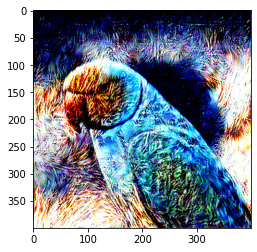

In [ ]:
plt.imshow(styled_img)